<a href="https://colab.research.google.com/github/Sreelekshmi688582/project/blob/main/lyric_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing libraries

import pandas as pd
import numpy as np

import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import re
import string

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
train = pd.read_csv('https://raw.githubusercontent.com/angelinakhatiwada/Emotion-Detection-in-Song-Lyrics/main/datasets/tweets_dataset.csv', index_col=0)
print(train.shape)
train.head()

(7102, 4)


,code,text,label,weight
0,10000,How the fu*k! Who the heck! moved my fridge!... should I knock the landlord door. #angry #mad ##,anger,0.938
1,10001,So my Indian Uber driver just called someone the N word. If I wasn't in a moving vehicle I'd have jumped out #disgusted,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered to a pick up store not my address #fuming #poorcustomerservice,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alarm in davis bc I was sound asleep #pissed #angry #upset #tired #sad #tired #hangry ######,anger,0.896
4,10004,"Don't join @BTCare they put the phone down on you, talk over you and are rude. Taking money out of my acc willynilly! #fuming",anger,0.896


In [6]:
# missing value check
def missing_value_check(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    return missing_value_df

In [7]:
missing_value_check(train)

,column_name,percent_missing
code,code,0.0
text,text,0.0
label,label,0.0
weight,weight,0.0


In [8]:
train['text'] = train['text'] .str.replace('&amp', '')

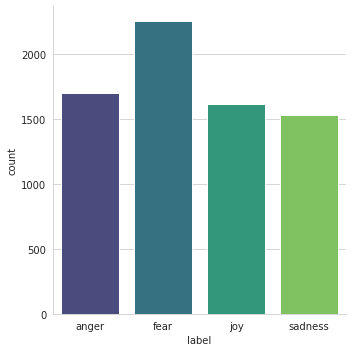

In [9]:
# plotting the distribution of emotions
sns.catplot(x="label", kind="count", palette="viridis", data=train)

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def visualize(label):
    words = ''
    for tweet in train[train['label'] == label]['text']:
        tweet = tweet.lower()
        words += tweet + ' '
    wordcloud = WordCloud(width=1000, height=1000, random_state=1, background_color='white').generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

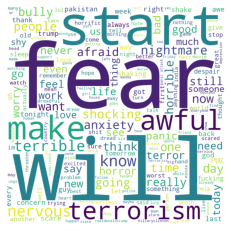

In [11]:
visualize('fear')

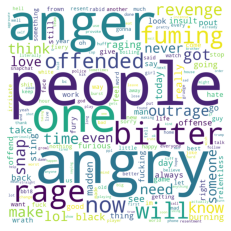

In [12]:
visualize('anger')

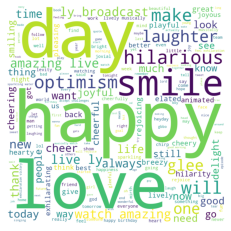

In [13]:
visualize('joy')

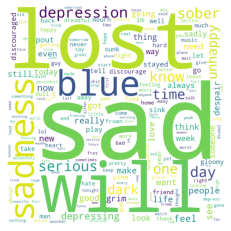

In [14]:
visualize('sadness')

In [15]:
# splitting into training and development sets
X_train, X_test, y_train , y_test = train_test_split(train,
                                                    train["label"],
                                                    stratify = np.array(train["label"]),
                                                    train_size=0.75, random_state = 42)

In [16]:
# uploading song lyrics dataset 
lyrics = pd.read_csv('https://raw.githubusercontent.com/angelinakhatiwada/Emotion-Detection-in-Song-Lyrics/main/datasets/song_lyrics_final_manually_labeled.csv', index_col =0)
lyrics['song_lyrics'] = lyrics['song_lyrics'].str.replace('EmbedShare URLCopyEmbedCopy', '')
lyrics = lyrics.rename(columns={'song_lyrics': "text"})
lyrics = lyrics.drop_duplicates()
print(lyrics.shape)

(600, 9)


In [17]:
# 40 manually labeled songs for testing
X_test_lyrics = lyrics[lyrics['label'].notnull()]
y_test_lyrics = X_test_lyrics['label']
X_test_lyrics.shape

(40, 9)

In [18]:
#Create CleanText transformer: lowercase, removing numbers, symbols, punctuation, english stopwords
class CleanText( BaseEstimator, TransformerMixin ):
    
    def __init__( self ):
        return 
    
    def fit( self, X, y = None ):
        return self 
    
    def clean( self, x ):
        stop = stopwords.words("english")
        stop = stop + list(string.punctuation)
        words  = [w for w in word_tokenize(x.lower()) if w.isalpha() and w not in stop]
        return " ".join(words)

    def transform( self, X, y = None ):
        return X["text"].apply(self.clean)

In [19]:
# Tf-IDF: unigrams and bigrams
tfidf_uni_bi = TfidfVectorizer(use_idf=True, min_df=2,
                analyzer='word',
                tokenizer=word_tokenize,
                ngram_range = (1,2))

In [20]:
# TF-IDF: char analyzer (3,6)
tfidf_char = TfidfVectorizer(use_idf=True, min_df=2,
                analyzer='char',
                ngram_range = (3,6))

In [21]:
# creating pipelines
pipe_cleaning = Pipeline([('clean', CleanText())])                      
                
pipe_extract_word = Pipeline([('clean', CleanText()), ('tfidf', tfidf_uni_bi)])

pipe_extract_char = Pipeline([('clean', CleanText()), ('tfidf', tfidf_char),
                              ("select", SelectKBest(score_func = chi2, k=15000))])

pipe_extract_char2 = Pipeline([('clean', CleanText()), ('tfidf', tfidf_char)])

In [22]:
tfidf_matrix_train_word = pipe_extract_word.fit_transform(X_train)
tfidf_matrix_test_word = pipe_extract_word.transform(X_test)
print(tfidf_matrix_train_word.shape)
print(tfidf_matrix_test_word.shape)

(5326, 10970)
(1776, 10970)


In [23]:
tfidf_matrix_train_char = pipe_extract_char.fit_transform(X_train, y_train)
tfidf_matrix_test_char = pipe_extract_char.transform(X_test)
print(tfidf_matrix_train_char.shape)
print(tfidf_matrix_test_char.shape)

(5326, 15000)
(1776, 15000)


In [24]:
lyrics['text'] = lyrics['text'].astype(str)
tfidf_matrix_train_lyrics_word = pipe_extract_word.fit_transform(lyrics)
print(tfidf_matrix_train_lyrics_word.shape)

(600, 8149)


In [25]:
tfidf_matrix_train_char2 = pipe_extract_char2.fit_transform(X_train, y_train)
tfidf_matrix_test_char2 = pipe_extract_char2.transform(X_test)
print(tfidf_matrix_train_char2.shape)
print(tfidf_matrix_test_char2.shape)

(5326, 112987)
(1776, 112987)


In [26]:
lyrics['text'] = lyrics['text'].astype(str)
tfidf_matrix_train_lyrics_word = pipe_extract_char2.fit_transform(lyrics)
print(tfidf_matrix_train_lyrics_word.shape)

(600, 99816)


In [27]:
cv = RepeatedKFold(n_splits=10, n_repeats= 5, random_state=1)

Accuracy score in validation set is,  0.868 with standard deviation =  0.0131 


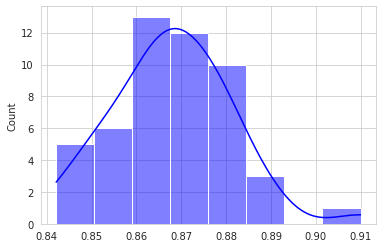

In [28]:
model = LogisticRegression()
scores = cross_val_score(model, tfidf_matrix_train_word, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Accuracy score in validation set is, {np.mean(scores) : .3f} with standard deviation = {np.std(scores) : .4f} ")
ax = sns.histplot(x=scores, kde=True, color = 'blue')

In [29]:
pipe_logistic = Pipeline([('pre_process', pipe_extract_word),
                          ('classify', LogisticRegression())])

pipe_logistic.fit(X=X_train, y=y_train)
y_preds = pipe_logistic.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       anger       0.91      0.83      0.87       426
        fear       0.81      0.93      0.86       563
         joy       0.94      0.90      0.92       404
     sadness       0.86      0.80      0.83       383

    accuracy                           0.87      1776
   macro avg       0.88      0.86      0.87      1776
weighted avg       0.87      0.87      0.87      1776



In [30]:
y_pred_lyrics = pipe_logistic.predict(X_test_lyrics)
print(classification_report(y_test_lyrics, y_pred_lyrics))

              precision    recall  f1-score   support

       anger       0.71      0.50      0.59        10
        fear       0.45      0.50      0.48        10
         joy       0.78      0.70      0.74        10
     sadness       0.54      0.70      0.61        10

    accuracy                           0.60        40
   macro avg       0.62      0.60      0.60        40
weighted avg       0.62      0.60      0.60        40



Accuracy score in validation set is,  0.858 with standard deviation =  0.0155 


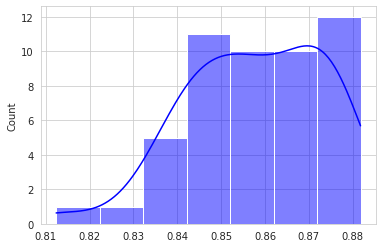

In [31]:
scores = cross_val_score(model, tfidf_matrix_train_char, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Accuracy score in validation set is, {np.mean(scores) : .3f} with standard deviation = {np.std(scores) : .4f} ")
ax = sns.histplot(x=scores, kde=True, color = 'blue')

In [32]:
pipe_logistic = Pipeline([('pre_process', pipe_extract_char),
                          ('classify', LogisticRegression())])

pipe_logistic.fit(X=X_train, y=y_train)
y_preds = pipe_logistic.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       anger       0.90      0.80      0.85       426
        fear       0.76      0.93      0.84       563
         joy       0.93      0.89      0.91       404
     sadness       0.87      0.74      0.80       383

    accuracy                           0.85      1776
   macro avg       0.86      0.84      0.85      1776
weighted avg       0.86      0.85      0.85      1776



In [33]:
y_pred_lyrics = pipe_logistic.predict(X_test_lyrics)
print(classification_report(y_test_lyrics, y_pred_lyrics))

              precision    recall  f1-score   support

       anger       0.88      0.70      0.78        10
        fear       0.47      0.80      0.59        10
         joy       0.67      0.60      0.63        10
     sadness       0.67      0.40      0.50        10

    accuracy                           0.62        40
   macro avg       0.67      0.62      0.63        40
weighted avg       0.67      0.62      0.63        40



Accuracy score in validation set is,  0.865 with standard deviation =  0.0144 


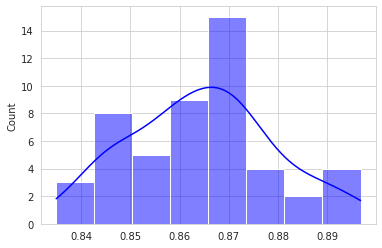

In [34]:
model = SVC()
scores = cross_val_score(model, tfidf_matrix_train_word, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Accuracy score in validation set is, {np.mean(scores) : .3f} with standard deviation = {np.std(scores) : .4f} ")
ax = sns.histplot(x=scores, kde=True, color = 'blue')

In [35]:
pipe_svm = Pipeline([('pre_process', pipe_extract_word),
                          ('classify', SVC())])

pipe_svm.fit(X=X_train, y=y_train)
y_preds = pipe_svm.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       anger       0.91      0.85      0.88       426
        fear       0.81      0.93      0.87       563
         joy       0.95      0.90      0.92       404
     sadness       0.87      0.78      0.82       383

    accuracy                           0.87      1776
   macro avg       0.88      0.87      0.87      1776
weighted avg       0.88      0.87      0.87      1776



In [36]:
y_pred_lyrics = pipe_svm.predict(X_test_lyrics)
print(classification_report(y_test_lyrics, y_pred_lyrics))

              precision    recall  f1-score   support

       anger       0.45      0.50      0.48        10
        fear       0.50      0.60      0.55        10
         joy       0.86      0.60      0.71        10
     sadness       0.50      0.50      0.50        10

    accuracy                           0.55        40
   macro avg       0.58      0.55      0.56        40
weighted avg       0.58      0.55      0.56        40



Accuracy score in validation set is,  0.894 with standard deviation =  0.0138 


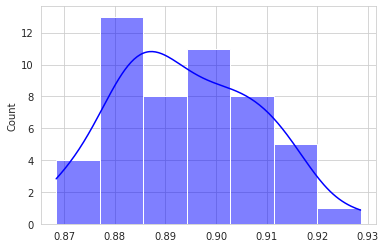

In [37]:
model = SVC()
scores = cross_val_score(model, tfidf_matrix_train_char, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Accuracy score in validation set is, {np.mean(scores) : .3f} with standard deviation = {np.std(scores) : .4f} ")
ax = sns.histplot(x=scores, kde=True, color = 'blue')

In [38]:
pipe_sgd = Pipeline([('pre_process', pipe_extract_word),
                          ('classify', SGDClassifier(random_state = 0, loss = 'log', early_stopping=True, class_weight='balanced'))])

pipe_sgd.fit(X=X_train, y=y_train)
y_preds = pipe_sgd.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       anger       0.91      0.87      0.89       426
        fear       0.87      0.89      0.88       563
         joy       0.91      0.93      0.92       404
     sadness       0.84      0.84      0.84       383

    accuracy                           0.88      1776
   macro avg       0.88      0.88      0.88      1776
weighted avg       0.88      0.88      0.88      1776



In [39]:
y_pred_lyrics = pipe_sgd.predict(X_test_lyrics)
print(classification_report(y_test_lyrics, y_pred_lyrics))

              precision    recall  f1-score   support

       anger       0.60      0.60      0.60        10
        fear       0.67      0.40      0.50        10
         joy       0.78      0.70      0.74        10
     sadness       0.47      0.70      0.56        10

    accuracy                           0.60        40
   macro avg       0.63      0.60      0.60        40
weighted avg       0.63      0.60      0.60        40



Accuracy score in validation set is,  0.878 with standard deviation =  0.0146 


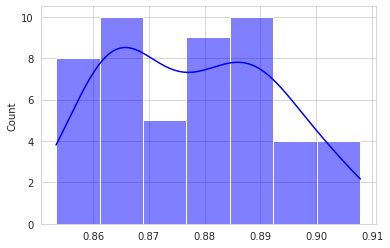

In [40]:
model = SGDClassifier(random_state = 0, loss = 'log', early_stopping=True, class_weight='balanced')
scores = cross_val_score(model, tfidf_matrix_train_char, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Accuracy score in validation set is, {np.mean(scores) : .3f} with standard deviation = {np.std(scores) : .4f} ")
ax = sns.histplot(x=scores, kde=True, color = 'blue')

In [41]:
pipe_sgd = Pipeline([('pre_process', pipe_extract_char),
                          ('classify', SGDClassifier(random_state = 0, loss = 'log', early_stopping=True, class_weight='balanced'))])

pipe_sgd.fit(X=X_train, y=y_train)
y_preds = pipe_sgd.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       anger       0.87      0.82      0.85       426
        fear       0.83      0.88      0.86       563
         joy       0.91      0.91      0.91       404
     sadness       0.84      0.83      0.83       383

    accuracy                           0.86      1776
   macro avg       0.86      0.86      0.86      1776
weighted avg       0.86      0.86      0.86      1776



['anger', 'fear', 'joy', 'sadness']


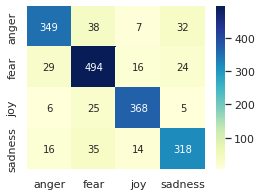

In [42]:
# confusion matrix for dev set
categories = list(set(list(train['label'])))
categories.sort()
print(categories)
df_cm  = pd.DataFrame(confusion_matrix(y_test, y_preds), range(4), range(4))
plt.figure(figsize= (4,3))
sns.set(font_scale=1)
sns.heatmap(df_cm, annot = True, annot_kws={"size":10},xticklabels= categories, yticklabels = categories, cmap ='YlGnBu', fmt='g' )
plt.show()

In [43]:
y_pred_lyrics = pipe_sgd.predict(X_test_lyrics)
print(classification_report( y_test_lyrics, y_pred_lyrics))

              precision    recall  f1-score   support

       anger       0.73      0.80      0.76        10
        fear       0.60      0.60      0.60        10
         joy       0.71      0.50      0.59        10
     sadness       0.58      0.70      0.64        10

    accuracy                           0.65        40
   macro avg       0.66      0.65      0.65        40
weighted avg       0.66      0.65      0.65        40



['anger', 'fear', 'joy', 'sadness']


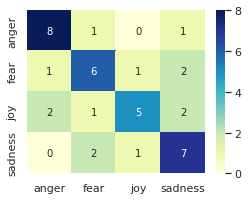

In [44]:
# confusion matrix for test set with song lyrics
categories = list(set(y_train))
categories.sort()
print(categories)
df_cm_lyrics  = pd.DataFrame(confusion_matrix(y_test_lyrics, y_pred_lyrics), range(4), range(4))
plt.figure(figsize= (4,3))
sns.set(font_scale=1)
sns.heatmap(df_cm_lyrics, annot = True, annot_kws={"size":10},xticklabels= categories, yticklabels = categories, cmap ='YlGnBu', fmt='g' )
plt.show()

In [45]:
#Create CleanText transformer: lowercase, removing numbers, symbols, punctuation, stopwords not removed
class CleanText2( BaseEstimator, TransformerMixin ):
    
    def __init__( self ):
        return 
    
    def fit( self, X, y = None ):
        return self 
    
    def clean( self, x ):
        stop = list(string.punctuation)
        words  = [w for w in word_tokenize(x.lower()) if w.isalpha() and w not in stop]
        return " ".join(words)

    def transform( self, X, y = None ):
        return X["text"].apply(self.clean)

# creating pipelines
pipe_cleaning_stop = Pipeline([('clean', CleanText2())])

In [46]:
X_train, X_test, y_train , y_test = train_test_split(train,
                                                    train["label"],
                                                    stratify = np.array(train["label"]),
                                                    train_size=0.75, random_state = 42)

X_test_lyrics = lyrics[lyrics['label'].notnull()]
y_test_lyrics = X_test_lyrics['label']

In [47]:
# The maximum number of words to be used (most frequent)
MAX_NB_WORDS = 20000
# Max number of words in each tweet/song
MAX_SEQUENCE_LENGTH = 1000
# emdedding dimensions
EMBEDDING_DIM = 200

In [48]:
X_train['cleaned_text'] =  pipe_cleaning.fit_transform(X_train)
X_test['cleaned_text'] = pipe_cleaning.transform(X_test)
X_test_lyrics['cleaned_text'] = pipe_cleaning.transform(X_test_lyrics)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train['cleaned_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train = tokenizer.texts_to_sequences(X_train['cleaned_text'].values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train data tensor:', X_train.shape)

X_test = tokenizer.texts_to_sequences(X_test['cleaned_text'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test data tensor:', X_test.shape)

X_test_lyrics = tokenizer.texts_to_sequences(X_test_lyrics['cleaned_text'].values)
X_test_lyrics = pad_sequences(X_test_lyrics, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test lyrics data tensor:', X_test_lyrics.shape)

Y_train = pd.get_dummies(y_train).values
print('Shape of train label tensor:', Y_train.shape)

Y_test= pd.get_dummies(y_test).values
print('Shape of test label tensor:', Y_test.shape)

Y_test_lyrics= pd.get_dummies(y_test_lyrics).values
print('Shape of test lyrics label tensor:', Y_test_lyrics.shape)

Found 11856 unique tokens.
Shape of train data tensor: (5326, 1000)
Shape of test data tensor: (1776, 1000)
Shape of test lyrics data tensor: (40, 1000)
Shape of train label tensor: (5326, 4)
Shape of test label tensor: (1776, 4)
Shape of test lyrics label tensor: (40, 4)


In [49]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 200)         4000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 1000, 200)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 4)                 404       
                                                                 
Total params: 4,120,804
Trainable params: 4,120,804
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
epochs = 5
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1)

Epoch 1/5
38/38 [==============================] - 262s 7s/step - loss: 1.3471 - accuracy: 0.3434 - val_loss: 1.2714 - val_accuracy: 0.3321
Epoch 2/5
38/38 [==============================] - 240s 6s/step - loss: 0.8924 - accuracy: 0.7127 - val_loss: 0.6734 - val_accuracy: 0.8330
Epoch 3/5
38/38 [==============================] - 245s 6s/step - loss: 0.2564 - accuracy: 0.9385 - val_loss: 0.4298 - val_accuracy: 0.8705
Epoch 4/5
38/38 [==============================] - 244s 6s/step - loss: 0.1104 - accuracy: 0.9658 - val_loss: 0.4099 - val_accuracy: 0.8818
Epoch 5/5
38/38 [==============================] - 245s 6s/step - loss: 0.0830 - accuracy: 0.9718 - val_loss: 0.4159 - val_accuracy: 0.8818


In [51]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy test tweets: {:0.3f}'.format(accr[0],accr[1]))

56/56 [==============================] - 22s 392ms/step - loss: 0.4315 - accuracy: 0.8677
Test set
  Loss: 0.432
  Accuracy test tweets: 0.868


In [52]:
accr = model.evaluate(X_test_lyrics,Y_test_lyrics)
print('Test set\n  Loss: {:0.3f}\n  Accuracy test lyrics: {:0.3f}'.format(accr[0],accr[1]))

2/2 [==============================] - 1s 439ms/step - loss: 1.8726 - accuracy: 0.4250
Test set
  Loss: 1.873
  Accuracy test lyrics: 0.425


In [53]:
# predicting talikng the best classifier
best_classifier = pipe_sgd
lyrics['text'] = lyrics['text'].astype(str)
y_pred_lyrics_all = pipe_sgd.predict(lyrics)
lyrics['emotion_pred'] = y_pred_lyrics_all

In [54]:
# SGD probablity score
y_score = pipe_sgd.predict_proba(lyrics)
score_emot_selected = np.round(np.amax(y_score, 1)*1, 2)
score_emot_selected.shape
lyrics['emotion_score'] = score_emot_selected

In [55]:
lyrics_genres = lyrics.groupby('genre')['emotion_pred'].value_counts(normalize=True).reset_index(name='percentage')

In [56]:
# percentage of emotion classed predicted in the lyrics dataset
lyrics['emotion_pred'].value_counts(normalize=True)

sadness    0.338333
fear       0.265000
joy        0.215000
anger      0.181667
Name: emotion_pred, dtype: float64

In [57]:
# percentage of emotion classed predicted in the lyrics dataset by genres
lyrics_genres

,genre,emotion_pred,percentage
0,Alternative Rock/Indie,fear,0.312500
1,Alternative Rock/Indie,anger,0.250000
2,Alternative Rock/Indie,sadness,0.250000
3,Alternative Rock/Indie,joy,0.187500
4,Blues,sadness,0.500000
5,Blues,fear,0.250000
6,Blues,anger,0.150000
7,Blues,joy,0.100000
8,Classic Rock,sadness,0.360000
9,Classic Rock,fear,0.280000


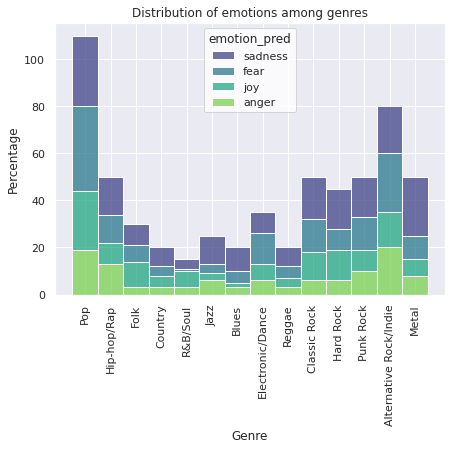

In [58]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
sns.set_style("white")

sns.histplot(data=lyrics, ax=ax, stat="count", multiple="stack",
             x="genre", kde=False,
             palette='viridis', hue="emotion_pred",
             element="bars", legend=True)
ax.set_title("Distribution of emotions among genres")
ax.set_xlabel("Genre")
ax.set_ylabel("Percentage")
ax.tick_params(axis='x', rotation=90)